---
<div align="center">
    
# S&P-500 | Stock Forecasting and Optimization
</div>

---

---
<div align="center">
    
## Problem Formulation
</div>

---

### Context

The stock market is **highly volatile and unpredictable** which makes **stock price forecasting** and **portfolio optimization** challenging tasks. Therefore, since investors seek strategies that can **provide risk-adjusted returns** efficiently, this project aims to help them.

### Resolution Approach

This project aims to leverage machine learning algorithms to **predict future stock prices of the S&P-500 Market Index** and subsequently **apply optimization techniques** to identify the **optimal set of stocks** for daily investment. The stock selection process focuses on **maximizing returns or minimizing risks**, addressing real-world financial challenges.

### Planned Work

To effectively **develop** this project, we have divided it into the following phases:

#### Data Preprocessing and Feature Engineering
   - **Extract** and **process** historical stock market data.  
   - **Engineer relevant features** such as moving averages and volatility measures.

#### Data Cleaning
   - Identify and **remove incongruent or invalid entries** from the stock market dataset.  
   - **Handle missing values, outliers, and inconsistencies** to ensure high-quality input data.

#### Exploratory Data Analysis (EDA)
   - Conduct in-depth analysis to understand **data distributions and trends**.  
   - Derive **actionable insights** to inform **feature selection** and modeling strategies.

#### Model Development and Evaluation
   - **Develop and evaluate predictive models**, including **LSTMs** (Long Short-Term Memory networks) and **LightGBM** (Light Gradient Boosting Machine).  
   - Implement a **sliding window** approach for training, where the model is **iteratively trained on data window** that moves forward by N days until reaching the end of the dataset.  
   - Ensure models are **tested using 2024 data** to assess predictive accuracy and generalization.
   - **Evaluate the predictive performance** of the models on the test data.

#### Portfolio Optimization
   - Apply **optimization techniques** such as Monte Carlo simulations, Min-Max strategies, and genetic algorithms.  
   - Optimize **portfolio selection** to balance the **trade-off between maximizing returns and minimizing risks**.

#### Results Analysis
   - Analyze **optimization outcomes** in the context of financial performance metrics.  
     
#### Final Considerations
   - Summarize findings and **evaluate the project's contribution** to financial forecasting and investment optimization.  

---
<div align="center">
    
## Project Dependencies

</div>

---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

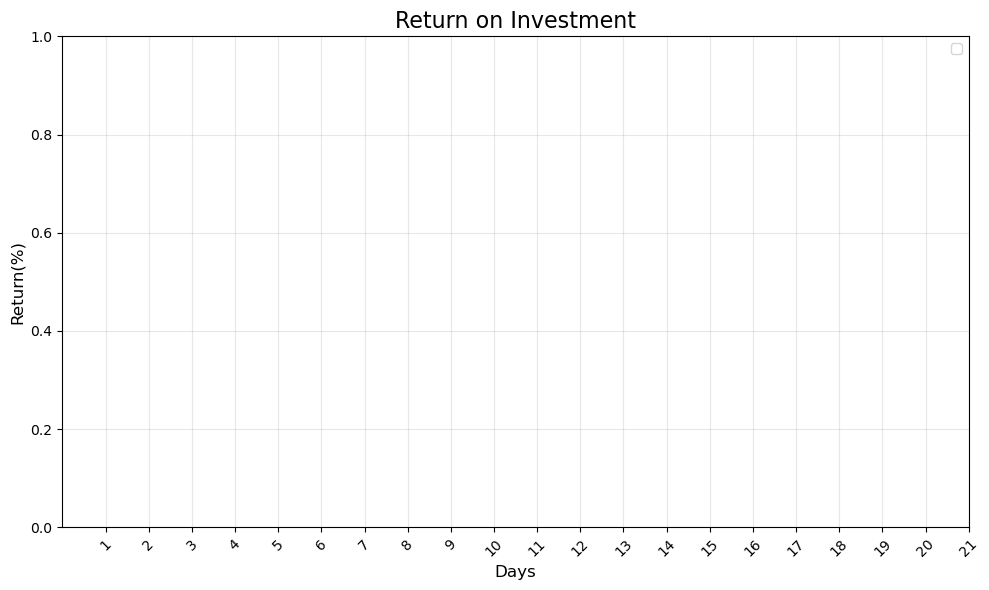

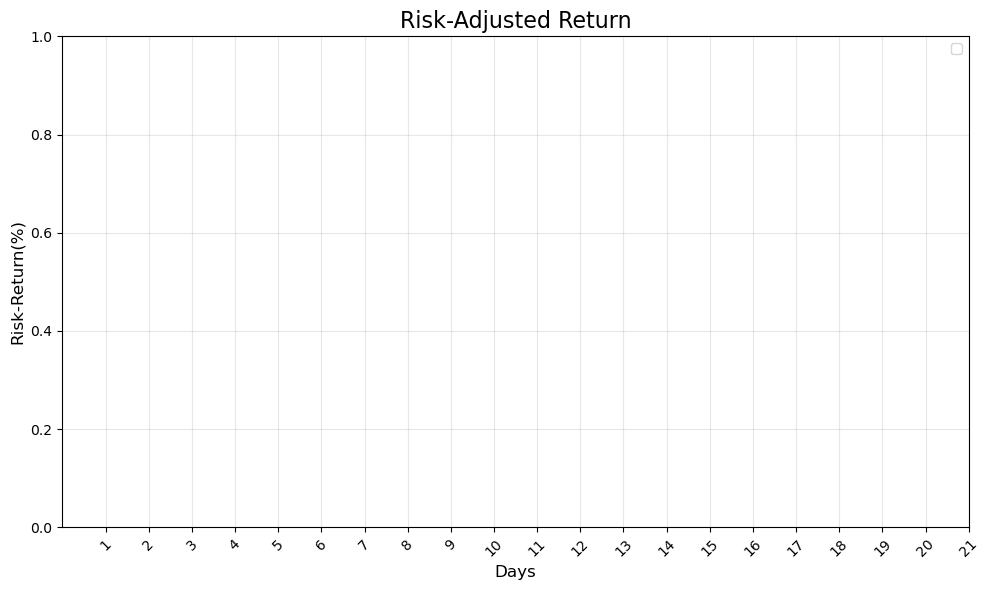

In [3]:
# Importing Dependencies
import numpy as np
import pandas as pd

# Import json to help save dictionaries into .json files
import json

# Import matplotlib to help visualize the data
import matplotlib.pyplot as plt

# Import Datetime to properly format the Dates from the Dataset
from datetime import (datetime, timedelta)
from datetime import datetime as dt

# Importing an API to handle the Datset from Yahoo Finance
import yfinance as yf
from yfinance import (Ticker)

# Import a Sequential Model from tensorflow alongside the Adam Optimizer and layers
from tensorflow.keras.models import (Sequential)
from tensorflow.keras.optimizers import (Adam)
from tensorflow.keras import (layers)

from DataPreProcessing.DataExtraction import (extractSP500StocksInformationWikipedia, getSP500StockMarketInformation, getStockMarketInformation, mergeStocksClosingPrices, selectStocksToUse)
from DataPreProcessing.DataVisualization import (plotFeatureDistribution, plotStockClosingPrice, plotStockStats)

from ModelDevelopmentAndEvaluation.StockPriceManager import (stockPriceManager)
from ModelDevelopmentAndEvaluation.StockPricePredictor import (StockPricePredictor)
from ModelDevelopmentAndEvaluation.DataManagement import (getStocksPredictions, getStocksOpeningPrices, getStocksClosingPrices, getStocksVolatility)
from ModelDevelopmentAndEvaluation.DataVisualization import (plotStocksRawResults)

from PortfolioOptimization.GeneticAlgorithm import (dailyInvestment)
from PortfolioOptimization.DataVisualization import (plotPortfolioPerformance)

from Utils.Configuration import (loadConfig, loadInitialPathsConfig, loadFinalPathsConfig, loadInitialSetup)

In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


In [5]:
# Load the configs
config = loadConfig()
pathsConfig = loadInitialPathsConfig()

---
<div align="center">

## Data Preprocessing
</div>

---

Our initial approach involved **analyzing the available data** to gain a deeper understanding of its distribution. This analysis serves as a **foundation for preprocessing the data** and subsequently feeding it into machine learning models, enabling us to later **predict the closing prices of multiple stocks for January 2024**.

---
### Exploratory Data Analysis
---

We began by analyzing a straightforward dataset containing various stocks along with **key information**, such as *Last Sale*, *Net Change*, and *Market Cap*.
> You can access this dataset [here](https://www.nasdaq.com/market-activity/stocks/screener)

In [6]:
# It consists of all the publicly available stocks globally
worldWideStocks = pd.read_csv('./Datasets/Stocks.csv')
worldWideStocks.head()

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,$139.65,2.780,2.031%,4.012531e+10,United States,1999.0,1795434,Industrials,Biotechnology: Laboratory Analytical Instruments
1,AA,Alcoa Corporation Common Stock,$40.73,0.160,0.394%,1.052279e+10,United States,2016.0,2930997,Industrials,Aluminum
2,AACG,ATA Creativity Global American Depositary Shares,$1.04,0.030,2.97%,3.328014e+07,China,2008.0,64843,Real Estate,Other Consumer Services
3,AACT,Ares Acquisition Corporation II Class A Ordina...,$10.87,-0.005,-0.046%,0.000000e+00,NaN,2023.0,26869,Finance,Blank Checks
4,AADI,Aadi Bioscience Inc. Common Stock,$1.96,-0.030,-1.508%,4.824508e+07,United States,NaN,24640,Health Care,Biotechnology: Pharmaceutical Preparations


In [7]:
# Extract some information of the S&P-500 Stocks from wikipedia
sp500Stocks = extractSP500StocksInformationWikipedia(pathsConfig)

# Compute the unique stocks
uniqueStocks = np.unique(sp500Stocks.Symbol.to_numpy())
print(f"There are {uniqueStocks.size} Unique Stocks out of {sp500Stocks.shape[0]} total Available Stocks on the S&P 500 Program.")

There are 503 Unique Stocks out of 503 total Available Stocks on the S&P 500 Program.


> Therefore each row corresponds to a **different stock**!

However, since the core focus of this project is the **S&P-500 Market Index Fund**, we narrowed our analysis to **stocks within this index to align with our objectives**. Additionally, to deepen our understanding of the composition of this market index, we extracted a **table from Wikipedia containing key details**, including the primary industry sectors (__*GICS Sector*__) and the years these companies were founded (__*Founded*__).

In [8]:
# Inspect the DataFrame
sp500Stocks.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",2000-06-05,1090872,1999
1,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977
2,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABNB,Airbnb,Consumer Discretionary,"Hotels, Resorts & Cruise Lines","San Francisco, California",2023-09-18,1559720,2008
4,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888


On a additional note, let's check the distribution of the S&P-500 Stocks throughout the available Industry Sectors, as to better infer which industry sectors provide the best candidates for our Portfolio Optimization task.

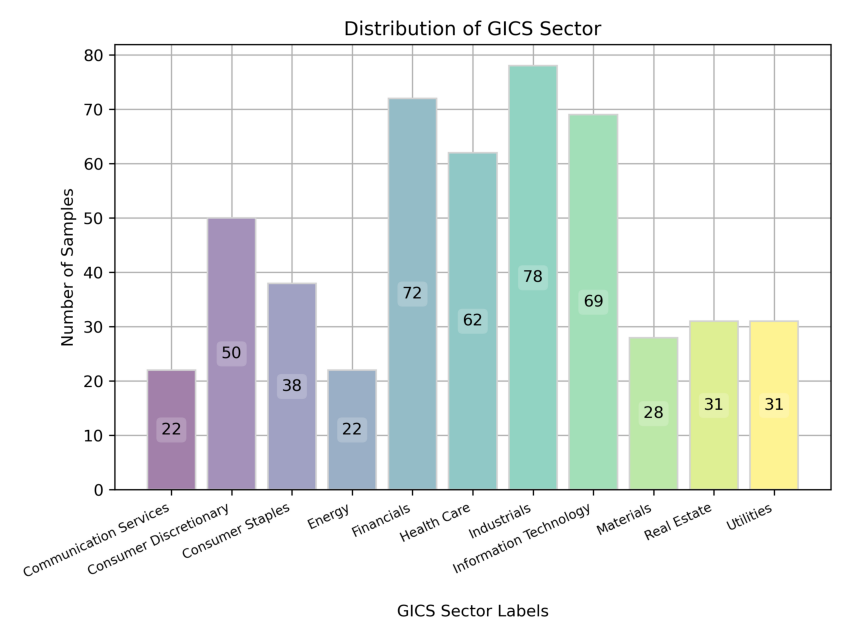

In [9]:
# Plot the Distribution for the GICS Sectors of all the Companies
plotFeatureDistribution(df=sp500Stocks, classFeature='GICS Sector', forceCategorical=False, pathsConfig=pathsConfig, featureDecoder=None)

As observed, the **majority of stocks** are concentrated in the **Financials**, **Health Care**, and **Industrials** sectors, with the remainder distributed across areas such as **Real Estate** and **Communication Services**.

Nevertheless, while analyzing sector distribution provides valuable context, our **primary focus is on the closing prices of the stocks within the index fund**. To streamline our analysis, we began by examining the **performance of this Market Index Fund over the past few years**.

In [10]:
# Extract a S&P-500 Stock Market Information
sp500MarketHistory = getSP500StockMarketInformation(config=config, pathsConfig=pathsConfig)

# Inpect the DataFrame
sp500MarketHistory.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily Return
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,3991400000,0.0,0.0,0.016043
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,2491020000,0.0,0.0,0.003116
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,4972660000,0.0,0.0,0.000546
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,5270680000,0.0,0.0,0.004001
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,4389590000,0.0,0.0,0.002882


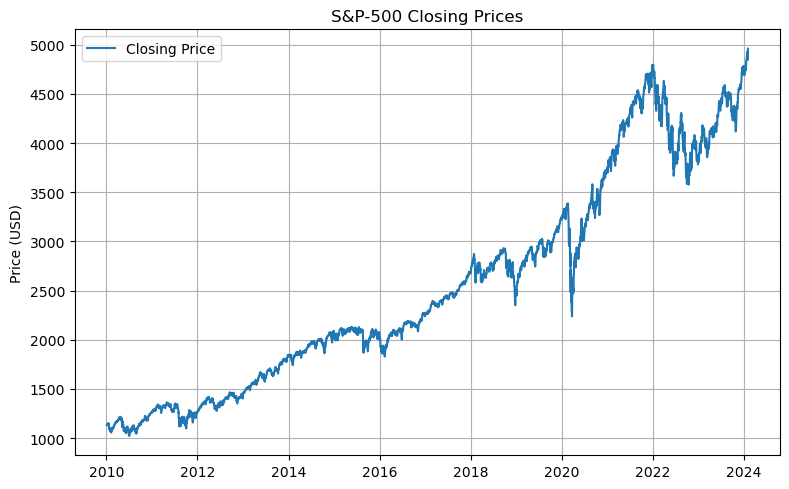

In [11]:
# Let's see a historical view of the closing price
plotStockClosingPrice(stockMarketHistory=sp500MarketHistory, title='S&P-500 Closing Prices')

Over the past decade, the S&P-500 Market Index has **experienced significant growth**, rising from ``$1,500`` in 2013 to over ``$4,500`` in 2024. This remarkable increase **highlights its potential as a lucrative investment** to enhance any investor's portfolio.

---
### Data Extraction and Feature Engineering
---

To address our task of **predicting the closing prices for each stock** in the market index for every open day in January 2024, we utilized the ``YFinance`` API to **extract the required data** efficiently.

#### Data Extraction
We began by **retrieving data for each stock within the S&P-500 Market Index** over the **maximal available interval** (2010 to 2024), even if some stocks started trading after 2010. This comprehensive datasets serve as the foundation for our closing price predictions, which are fulcral to perform subsequent portfolio optimization.

#### Feature Engineering
To gain deeper insights into **stock price fluctuation** over time and enhance our predictive models, we introduced **several key features**:

- ``SMA (Simple Moving Average)`` : Tracks **average prices over a fixed window** to identify trends.  
- ``EMA (Exponential Moving Average`` : Places **greater weight on recent prices** for trend detection.  
- ``Bollinger Bands`` : Measures **price volatility** and relative highs / lows.  
- ``Daily Return`` : Calculates **percentage changes** between consecutive closing prices.  
- ``Cumulative Return`` : Tracks the **aggregated return** over a specified period.  
- ``Window Return`` : Aggregates **returns over a rolling window**.  
- ``Volatility`` : Quantifies the **degree of variation in stock prices over time**.

> These features provide a richer context for **understanding price dynamics**.

First and foremost we will filter the **specific dates on which we aim to perform inference** — these will define the time frame considered for subsequent **portfolio optimization**.

In [12]:
# Extract the dates in which the market is open in January 2024 - Days in which we are going to perform inference
predictionDates = sp500MarketHistory[sp500MarketHistory['Date'] >= str(dt(2024, 1, 1).date())][sp500MarketHistory['Date'] < str(dt(2024, 2, 1).date())]['Date'].to_numpy()
predictionDates

array(['2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05',
       '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11',
       '2024-01-12', '2024-01-16', '2024-01-17', '2024-01-18',
       '2024-01-19', '2024-01-22', '2024-01-23', '2024-01-24',
       '2024-01-25', '2024-01-26', '2024-01-29', '2024-01-30',
       '2024-01-31'], dtype=object)

In [13]:
# Let's update the paths dictionary to include the paths in which to save the Extracted Data and Trained Models
pathsConfig = loadFinalPathsConfig(stocks=uniqueStocks, predictionDates=predictionDates)

Consequently, for simplicity, we initially focused on a **single stock**, selecting ``NVDA``. This approach serves as a foundation, which **we will later extend to include all the remaining stocks**.

---
### NVDA Stock
---

In [14]:
# Extract a Stock's Market Information
stockMarketHistory = getStockMarketInformation(stockSymbol='NVDA', config=config, pathsConfig=pathsConfig)
stockMarketHistory.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA,EMA,UpperBB,LowerBB,Daily_Return,Cumulative_Return,Window_Return,Volatility
0,2010-01-04,0.424410,0.426933,0.415239,0.423952,800204000,0.0,0.0,0.386383,0.388421,0.448433,0.324333,-0.010171,1.324499,0.336949,0.105565
1,2010-01-05,0.422347,0.434728,0.422347,0.430143,728648000,0.0,0.0,0.391542,0.392395,0.449835,0.333250,0.014602,1.343840,0.315568,0.102702
2,2010-01-06,0.429913,0.433811,0.425786,0.432894,649168000,0.0,0.0,0.394741,0.396252,0.454801,0.334681,0.006397,1.352436,0.173400,0.104711
3,2010-01-07,0.430601,0.432435,0.421200,0.424410,547792000,0.0,0.0,0.398409,0.398934,0.456148,0.340670,-0.019598,1.325931,0.209013,0.100835
4,2010-01-08,0.420971,0.428308,0.418449,0.425328,478168000,0.0,0.0,0.401688,0.401447,0.457603,0.345773,0.002161,1.328797,0.182282,0.101442


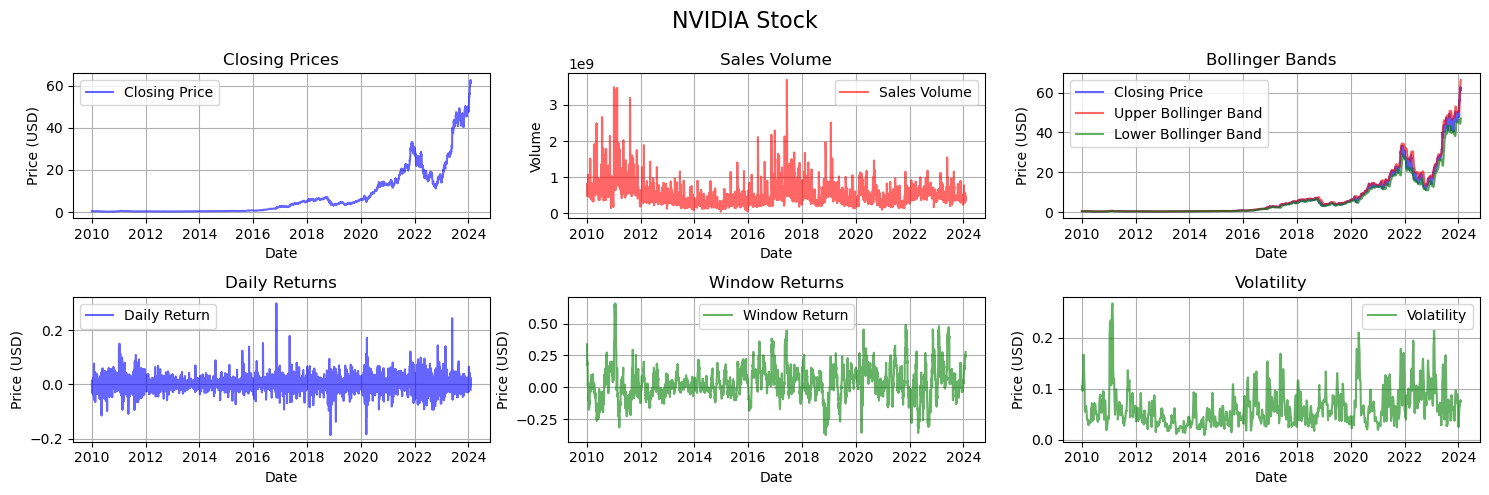

In [15]:
# Plotting the NVIDIA Statistics over the years
plotStockStats(stockMarketHistory=stockMarketHistory, title='NVIDIA Stock')

The ``NVDA stock`` has performed **relatively well** over the past few years, demonstrating **notable daily and window returns**, coupled with **low volatility** and a **high volume of sales**.

To prepare the data for **training** our machine learning models, we adapted the **Closing Prices** (sequential data) using an ``overlapping rolling window approach``. This involves defining a **fixed window size** — **20 days** in our case — and sliding it **forward one day at a time**. For each window, the **final day serves as the target value for prediction**, while the **preceding days** are used as **input features** for inference during training.

For **testing**, we apply the **same rolling window approach**. Each **open market day in January 2024 is treated as a target prediction date**. The prediction uses the**previous 19 days of data as input**, which **may include days from January 2024** if the target prediction date exceeds the first 20 days of the month.

In [16]:
# Create a instance of a stock price manager
ds = stockPriceManager(stockSymbol='NVDA', feature='Close', windowSize=config['window'], predictionDate='2024-01-02', pathsConfig=pathsConfig)

# Split the data accordingly
x_train, y_train, x_test, y_test = ds.trainTestSplit()

# Print the train and test set's shapes
print(f"X_train: {x_train.shape} \t y_train: {y_train.shape}")
print(f"X_test: {x_test.shape} \t y_test: {y_test.shape}")

X_train: (3502, 19) 	 y_train: (3502,)
X_test: (1, 19) 	 y_test: (1,)


After processing the data, the next step is to use it to **train our models** and **evaluate their performance using specific metrics**.

In [17]:
# Create a instace of a Stock Price Predictor
nvdaPredictor = StockPricePredictor(stockSymbol="NVDA", datesToPredict=predictionDates, config=config, pathsConfig=pathsConfig)

We employed a **variety of machine learning algorithms**, encompassing both classical and deep learning approaches:

- **Random Forest**
- **LGBM (Light Gradient Boosting Machine)**
- **XGBoost (Extreme Gradient Boosting)**
- **LSTM (Long Short-Term Memory)**

To **assess the performance of our models**, we selected two key evaluation metrics:

- **Mean Absolute Error (MAE):**  
  Measures the **average magnitude of errors** in predictions, providing a straightforward understanding of the model's accuracy.  

- **Mean Absolute Percentage Error (MAPE):**  
  Expresses the **prediction error as a percentage of the actual values**, offering an **intuitive metric** for comparing performance across different scales.  

In [18]:
# Train the selected models to perform inference
nvdaRawForecast, nvdaForecast = nvdaPredictor.trainModels()

In [19]:
# Check the raw predictions for the NVDA Stock over the first 5 days of January 2024
nvdaRawForecast.head()

,Date,[Random Forest] Prediction,[Random Forest] Mean Absolute Error,[Random Forest] Mean Absolute Percentage Error (%),[LGBM] Prediction,[LGBM] Mean Absolute Error,[LGBM] Mean Absolute Percentage Error (%),[XGBoost] Prediction,[XGBoost] Mean Absolute Error,[XGBoost] Mean Absolute Percentage Error (%),[LSTM] Prediction,[LSTM] Mean Absolute Error,[LSTM] Mean Absolute Percentage Error (%),Target
0,2024-01-02,39.176,0.784,1.961,41.949,1.989,4.978,39.352,0.608,1.522,39.027,0.934,2.336,39.960
1,2024-01-03,39.313,0.444,1.143,41.912,3.043,7.829,39.016,0.147,0.379,39.063,0.195,0.501,38.869
2,2024-01-04,38.723,0.337,0.878,40.491,2.105,5.483,38.345,0.041,0.107,39.072,0.687,1.789,38.386
3,2024-01-05,38.550,0.182,0.470,40.845,2.113,5.457,37.614,1.117,2.885,38.625,0.107,0.276,38.732
4,2024-01-08,38.595,1.023,2.581,42.087,2.469,6.233,37.955,1.662,4.196,39.271,0.347,0.875,39.618


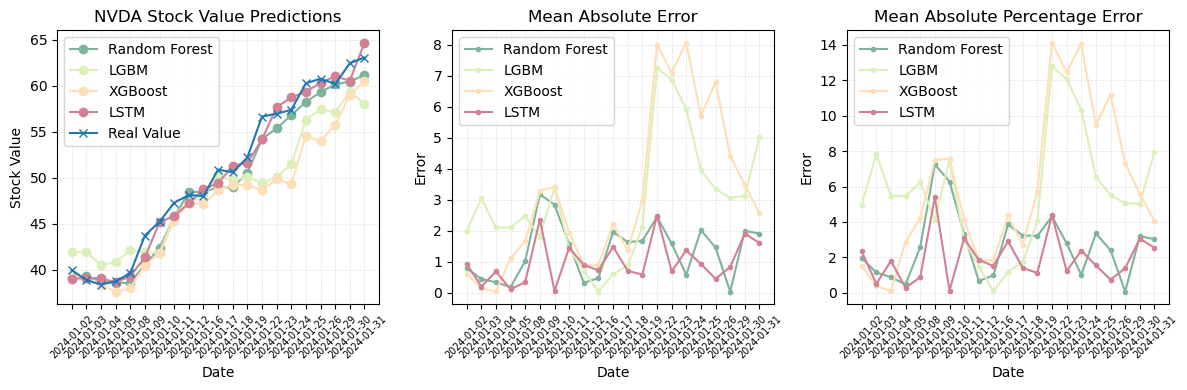

In [20]:
# Plot the Prediction results for the NVDA Stock
plotStocksRawResults(stockSymbol='NVDA', pathsConfig=pathsConfig)

As observed, **most models performed relatively well**, with clear evidence that the **LSTM** network architecture achieved the **best performance** among the selected models. However, the **final prediction** is determined by **averaging the predictions** from all the trained models.

In [21]:
# Check the price forecasting for the NVDA Stock for the first 5 days of January 2024
nvdaForecast.head()

,Date,NVDA
0,2024-01-02,39.876
1,2024-01-03,39.826
2,2024-01-04,39.158
3,2024-01-05,38.908
4,2024-01-08,39.477


---
### Remaining Stocks
---

Given the **vast number of stocks in the S&P-500 Market Index Fund** and the **high computational costs** associated with **training models for all of them**, we opted to use only a subset. To ensure a **representative sample**, we carefully selected the **5 top-performing stocks from each GICS sector** based on *Market Cap*, *Percentage Change*, and *Volume of Sales*, resulting in a total of `` 55 stocks ``.

In [22]:
# Select the most important stocks per Industry Sector
selectedStocks = selectStocksToUse(worldWideStocks=worldWideStocks, sp500Stocks=sp500Stocks, numberStocks=5)
selectedStocks.head()

,Symbol,Name,Sector
0,GOOGL,Alphabet Inc. Class A Common Stock,Communication Services
1,GOOG,Alphabet Inc. Class C Capital Stock,Communication Services
2,META,Meta Platforms Inc. Class A Common Stock,Communication Services
3,FOXA,Fox Corporation Class A Common Stock,Communication Services
4,FOX,Fox Corporation Class B Common Stock,Communication Services


We then applied the **same procedure used for the NVDA stock** to all the selected stocks. This involved **retrieving their historical market data**, **preparing it for training**, and **managing the results** to subsequently use them for **portfolio optimization**.

In [23]:
# Create a vector to store all the extracted stocks
extractedStocks = []

# Extract the market informations for all stocks
for symbol in selectedStocks.Symbol:
    X = getStockMarketInformation(stockSymbol=symbol, config=config, pathsConfig=pathsConfig)
    if X is None:
        pass
    else:
        # Update the extracted stocks list
        extractedStocks.append(symbol)

In [24]:
# Iterate through the extracted data
for symbol in extractedStocks:
    # Compute a windowed DataFrame to be later used to feed our models
    _ = stockPriceManager(stockSymbol=symbol, feature='Close', windowSize=config['window'], predictionDate='2024-01-01', pathsConfig=pathsConfig)

In [25]:
# Iterate through the selected stocks
for stockSymbol in extractedStocks:
    # Create a instance of a StockPricePredictor for the current Stock
    stockPredictor = StockPricePredictor(stockSymbol=stockSymbol, datesToPredict=predictionDates, config=config, pathsConfig=pathsConfig)

    # Compute the models to predict the closing prices of each day in January 2024
    stockPredictor.trainModels()

Additionally, we organized all the computed data into multiple DataFrames, presenting the **real open and close prices** for each stock, the corresponding **volatility**, and the **prediction values** generated by the trained models.

In [26]:
# Get all the extracted stocks opening prices
stocksOpeningPrices = getStocksOpeningPrices(stocks=extractedStocks, pathsConfig=pathsConfig)
stocksOpeningPrices.head(3)

,Date,GOOGL_Open,GOOG_Open,META_Open,FOXA_Open,FOX_Open,AMZN_Open,EBAY_Open,F_Open,TPR_Open,...,PSA_Open,SPG_Open,MAA_Open,UDR_Open,CSGP_Open,AES_Open,NEE_Open,PPL_Open,CNP_Open,NRG_Open
0,2024-01-02,138.207771,139.258020,350.265388,29.210862,27.322692,151.539993,42.614953,11.252438,35.935504,...,296.042341,136.615494,127.976370,36.641264,86.870003,18.384008,58.836711,26.286978,27.717489,50.325069
1,2024-01-03,136.910985,138.260461,343.944422,29.683435,27.529161,149.199997,42.979444,11.233747,36.784836,...,300.070863,136.230598,129.193560,36.708350,85.250000,18.355195,59.380865,26.773774,28.203422,50.178489
2,2024-01-04,138.078085,139.507407,343.465873,29.762197,27.558655,145.589996,42.880929,10.990754,36.062416,...,293.324313,134.748776,126.184148,36.056609,82.370003,18.335984,60.410876,27.017174,28.426947,50.686620


In [27]:
# Get all the extracted stocks closing prices
stocksClosingPrices = getStocksClosingPrices(stocks=extractedStocks, pathsConfig=pathsConfig)
stocksClosingPrices.head(3)

,Date,GOOGL_Close,GOOG_Close,META_Close,FOXA_Close,FOX_Close,AMZN_Close,EBAY_Close,F_Close,TPR_Close,...,PSA_Close,SPG_Close,MAA_Close,UDR_Close,CSGP_Close,AES_Close,NEE_Close,PPL_Close,CNP_Close,NRG_Close
0,2024-01-02,137.828705,139.218109,345.250488,29.772041,27.666805,149.929993,43.215858,11.364589,37.263191,...,302.701508,137.625824,130.190292,37.034225,85.459999,18.576109,59.827850,26.783510,28.193701,50.080772
1,2024-01-03,138.576859,140.016144,343.435944,29.535757,27.499664,148.470001,42.900635,10.944024,35.974552,...,294.139740,134.796890,126.701691,36.094948,82.769997,18.182304,60.235966,26.929548,28.310326,50.491188
2,2024-01-04,136.053101,137.701828,346.078003,29.594828,27.519327,144.570007,41.895840,10.915987,36.023369,...,291.392548,134.960464,126.663353,36.286636,81.419998,18.124674,60.051346,26.890608,28.261730,50.119854


In [28]:
# Get all the extracted stocks volatility Values
stocksVolatility = getStocksVolatility(stocks=extractedStocks, pathsConfig=pathsConfig)
stocksVolatility.head(3)

,Date,GOOGL_Volatility,GOOG_Volatility,META_Volatility,FOXA_Volatility,FOX_Volatility,AMZN_Volatility,EBAY_Volatility,F_Volatility,TPR_Volatility,...,PSA_Volatility,SPG_Volatility,MAA_Volatility,UDR_Volatility,CSGP_Volatility,AES_Volatility,NEE_Volatility,PPL_Volatility,CNP_Volatility,NRG_Volatility
0,2024-01-02,0.023369,0.023706,0.027976,0.019350,0.015006,0.013903,0.019204,0.058000,0.024148,...,0.043977,0.032929,0.027421,0.035201,0.022773,0.027676,0.033884,0.014931,0.030755,0.027229
1,2024-01-03,0.026700,0.027219,0.029616,0.018105,0.014433,0.014222,0.018569,0.051283,0.028830,...,0.040039,0.035785,0.025439,0.031233,0.027510,0.029729,0.030644,0.015560,0.031748,0.027341
2,2024-01-04,0.027004,0.027723,0.031610,0.017129,0.014704,0.018416,0.019233,0.044937,0.030493,...,0.037601,0.038757,0.024935,0.028883,0.031368,0.033375,0.026371,0.016943,0.032214,0.027287


In [29]:
# Merge all the stock predictions into a single DataFrame
stockPredictions = getStocksPredictions(stocks=extractedStocks, pathsConfig=pathsConfig)
stockPredictions.head(3)

,Date,GOOGL,GOOG,META,FOXA,FOX,AMZN,EBAY,F,TPR,...,PSA,SPG,MAA,UDR,CSGP,AES,NEE,PPL,CNP,NRG
0,2024-01-02,135.978,137.125,339.780,29.367,27.367,153.308,43.017,11.560,36.414,...,297.210,138.802,129.030,37.013,87.578,18.559,59.395,26.577,27.718,48.075
1,2024-01-03,136.113,136.361,335.113,29.258,27.083,152.222,42.922,11.363,35.843,...,295.253,137.909,128.844,36.513,87.181,18.516,58.617,26.383,27.799,47.858
2,2024-01-04,134.073,134.912,330.401,29.884,27.760,149.541,43.197,11.332,37.642,...,307.272,137.493,130.144,36.861,84.674,18.635,59.736,26.834,28.316,47.848


---

<div align="center">

## Portfolio Optimization 
</div>

---

In this new section, we are going to manage the portfolio optimization section of the project to try and provide a tool to assist investors to properly manage their assets so that they can maximize their Return of Investment (ROI) while minimizing the adjacent Risks.

---
### Initial Setup
---

In order to perform the Portfolio Optimization we first need to define the Initial Constraints to which we are trying to converge the solution with.
These Aspects involve not only the dispensed money to invest in these stocks but also the Risk Free Ratio which we are going to consider when trying to minimize the risks of investment over the previously selected stocks. 

In [30]:
# Load the Initial Setup
initialSetup = loadInitialSetup()
initialSetup

{'initialMoney': 1000,
 'buyFee': 1,
 'sellFee': 1,
 'limitStocksPerDay': 100,
 'minimizeRisk': True,
 'maximizeRisk': False,
 'minimizeReturn': False,
 'maximizeReturn': True}

In [31]:
currentPortfolioEval = 10000
numberStocks = stockPredictions.shape[1] - 1
numberDays = stockPredictions.shape[0]
riskFreeRate = 0.00959
values = [currentPortfolioEval]
returns = []
riskReturns = []

In [32]:
# Perform Daily Investment
for day in range (0, numberDays):
    values, returns, riskReturns = dailyInvestment(numberStocks=numberStocks, day=day, current_value=currentPortfolioEval,
                                                   riskFreeRate=riskFreeRate, values=values, returns=returns, riskReturns=riskReturns, 
                                                   stocksOpeningPrices=stocksOpeningPrices, stocksClosingPrices=stocksClosingPrices,
                                                   stocksPredictedClosingPrices=stockPredictions, stocksVolatility=stocksVolatility)

Generation 1 complete
Fitness of the best solution: 151.59882391135505
Generation 2 complete
Fitness of the best solution: 153.2801383081636
Generation 3 complete
Fitness of the best solution: 153.2801383081636
Generation 4 complete
Fitness of the best solution: 153.2801383081636
Generation 5 complete
Fitness of the best solution: 153.2801383081636
Generation 6 complete
Fitness of the best solution: 153.2801383081636
Generation 7 complete
Fitness of the best solution: 153.2801383081636
Generation 8 complete
Fitness of the best solution: 153.2801383081636
Generation 9 complete
Fitness of the best solution: 155.40021712361892
Generation 10 complete
Fitness of the best solution: 155.47952846866966
Generation 11 complete
Fitness of the best solution: 155.47952846866966
Generation 12 complete
Fitness of the best solution: 155.47952846866966
Generation 13 complete
Fitness of the best solution: 155.47952846866966
Generation 14 complete
Fitness of the best solution: 155.47952846866966
Generati

KeyboardInterrupt: 

### Financial Metrics

1. Invested Money in a day

2. Total Return
    - It measures the total return of an investment

3. Return on Investment  
    - It measures the percentage return on an investment

4. Risk-Adjusted Return  
    - Performance of an investment given the Risk taken

## Genetic Model
We created a genetic model to that adjust the number os stocks that we buy for each company, based on the expected returns of each company for that day. If a return is expected to be negative, the weght is automatically 0, else it can be a value in the range of 0 to 10. If the value invested is negative or above budget the return of the fitness function is -infinite, so that the model does't develop those values

The model is initialized with weights zero for companies with expected return negative or volatility below 0.030. In a day we invest in a maximum of 5 companies and 20 stocks per company. The model does 50 iterations to analyse the best options of stocks to buy and sell in that day

<div align="center">
    
---
## Conclusions
---
</div>

> ADD CONCLUSIONS

<div align="center">

---
## Bibliographic References
---
</div>

1. AUTHOR (YEAR). __*TITLE*__. Available [here](_LINK_)

LINKS:
- https://medium.com/@kasperjuunge/yfinance-10-ways-to-analyze-stock-prices-18d2062ab35c
- https://www.digitalocean.com/community/tutorials/genetic-algorithm-applications-using-pygad  

___
## Video Presentation (YouTube Video)

Moreover, you can find the **Video** for our **Project's Presentation [here](https://youtu.be/dQw4w9WgXcQ?si=M2fOqMOebz5GcYoj)**
___
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Francisco Macieira](https://github.com/franciscovmacieira) &#8594; `up202207166@edu.fc.up.pt`
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@edu.fc.up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@edu.fc.up.pt`